# Generate Markers

In [1]:
import cv2
import cv2.aruco as aruco
import numpy as np

# Define the dictionary we will use (4x4 grid is robust and simple)
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)

# Size of the marker image in pixels (high res for printing)
marker_size_px = 500
border_bits = 1

# --- Generate Marker ID 0 (Top Anchor) ---
marker_img_0 = np.zeros((marker_size_px, marker_size_px), dtype=np.uint8)
aruco.generateImageMarker(aruco_dict, 0, marker_size_px, marker_img_0, border_bits)
cv2.imwrite("marker_top_id0.png", marker_img_0)

# --- Generate Marker ID 1 (Bottom Anchor) ---
marker_img_1 = np.zeros((marker_size_px, marker_size_px), dtype=np.uint8)
aruco.generateImageMarker(aruco_dict, 1, marker_size_px, marker_img_1, border_bits)
cv2.imwrite("marker_bot_id1.png", marker_img_1)

print("Success! Two marker images generated: 'marker_top_id0.png' and 'marker_bot_id1.png'")
print("Print these out.")

Success! Two marker images generated: 'marker_top_id0.png' and 'marker_bot_id1.png'
Print these out.


In [4]:
!pip install opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 151.2 MB/s eta 0:00:0000:0100:01


# Calibration and Measurement

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_frame(frame, title: str = "Video Frame", figsize: tuple = (2, 8)):
    """
    Displays a single video frame (as a NumPy array) using Matplotlib.

    This function assumes the input frame is in BGR format (as read by OpenCV)
    and will convert it to RGB for correct display.

    Args:
        frame (np.ndarray): The frame to display, expected to be a NumPy array.
        title (str, optional): The title for the Matplotlib plot. 
                               Defaults to "Video Frame".
        figsize (tuple, optional): The figure size for the Matplotlib plot. 
                                   Defaults to (10, 8).
    """
    # Step 1: Check if the frame is valid
    if frame is None:
        print("Error: The provided frame is empty.")
        return

    # Step 2: IMPORTANT - Convert color space from BGR to RGB
    # OpenCV reads frames in BGR, but Matplotlib displays in RGB.
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Step 3: Display the frame using Matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(frame_rgb)
    plt.title(title)
    plt.axis('tight')  # Hide the axes for a cleaner image
    plt.show()

In [29]:
def get_video_properties(cap):
    fps          = cap.get(cv2.CAP_PROP_FPS)
    frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    frame_width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    return fps, frame_height, frame_width
    

In [92]:
def calibrate(first_frame, physical_separation):

    # --- AUTO-CALIBRATION WITH ARUCO ---
    print("Attempting automatic calibration...")
    gray_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
    parameters = aruco.DetectorParameters()

    # display_frame(first_frame)
    
    # Detect markers
    corners, ids, _ = aruco.detectMarkers(gray_frame, aruco_dict, parameters=parameters)
    
    if ids is None or len(ids) < 2:
        print("Error: Could not find both markers (ID 0 and ID 1).")
        print("Ensure they are visible and lighting is okay.")
        return

    # Find the y-center of ID 0 and ID 1
    # ids is a list of arrays, flatten it to search
    ids_flat = ids.flatten()
    
    try:
        idx0 = np.where(ids_flat == 0)[0][0]
        idx1 = np.where(ids_flat == 1)[0][0]
        print(corners[idx0])
        print(corners[idx1])      
        
        # Calculate center Y-coordinate for each marker
        # corners[i][0] is a 4x2 array of (x,y) points for the marker square
        y_center_0 = corners[idx0][0][:, 1].mean()
        y_center_1 = corners[idx1][0][:, 1].mean()
        
        # Calculate calibration factor
        pixel_distance = abs(y_center_1 - y_center_0)
        pixels_per_inch = pixel_distance / physical_separation
        
        print(f"SUCCESS: Found markers. Pixel distance: {pixel_distance:.1f}")
        print(f"CALIBRATION: {pixels_per_inch:.2f} pixels/inch")
        return pixels_per_inch, corners
        
    except IndexError:
        print("Error: Found markers, but not specifically ID 0 and ID 1.")
        return None

In [ ]:
import cv2
import cv2.aruco as aruco
import numpy as np

# --- CONFIGURATION ---
VIDEO_PATH = 'data/full-height.mp4'  # Replace with your video file
REAL_DISTANCE_inches = 75.67

# HSV Color Range for your yellow ball (adjust as needed)
HSV_LOWER = (20, 100, 100)
HSV_UPPER = (40, 255, 255)
# ---------------------

In [83]:
cap = cv2.VideoCapture('data/full-height.mp4')
print(get_video_properties(cap))

(59.94005994005994, 3840.0, 2160.0)


In [93]:
# 1. Read first frame for calibration
ret, first_frame = cap.read()
if not ret:
    print("Error reading video.")
pixels_per_inch, corners = calibrate(first_frame, 75.67)

Attempting automatic calibration...
[[[545. 333.]
  [806. 332.]
  [804. 590.]
  [544. 590.]]]
[[[ 535. 3219.]
  [ 801. 3221.]
  [ 798. 3487.]
  [ 532. 3484.]]]
SUCCESS: Found markers. Pixel distance: 2891.5
CALIBRATION: 38.21 pixels/inch


In [109]:
# Find the left most part of the two IDs
min_left = np.array(corners)[:, 0].min()

crop_left  = np.int32(min_left - 1 * pixels_per_inch)
crop_right = np.int32(crop_left + 25 * pixels_per_inch)

cropped_frame = first_frame[:, crop_left:crop_right]

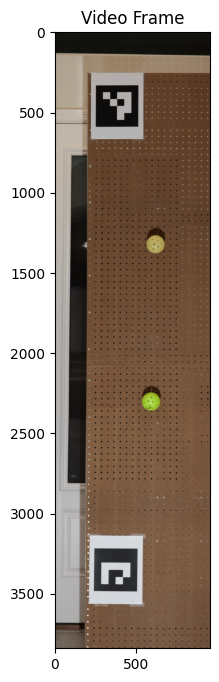

In [110]:
display_frame(cropped_frame)

In [117]:
# Radius limits for balls.
min_ball_radius_inches = 2.87 / 2
max_ball_radius_inches = 2.97 / 2
min_ball_r_pixels = 0.9 * min_ball_radius_inches * pixels_per_inch
max_ball_r_pixels = 1.1 * max_ball_radius_inches * pixels_per_inch
# min_ball_r_pixels, max_ball_r_pixels

Detected Balls Information:
[{'center': (590, 2304), 'radius': 50}]


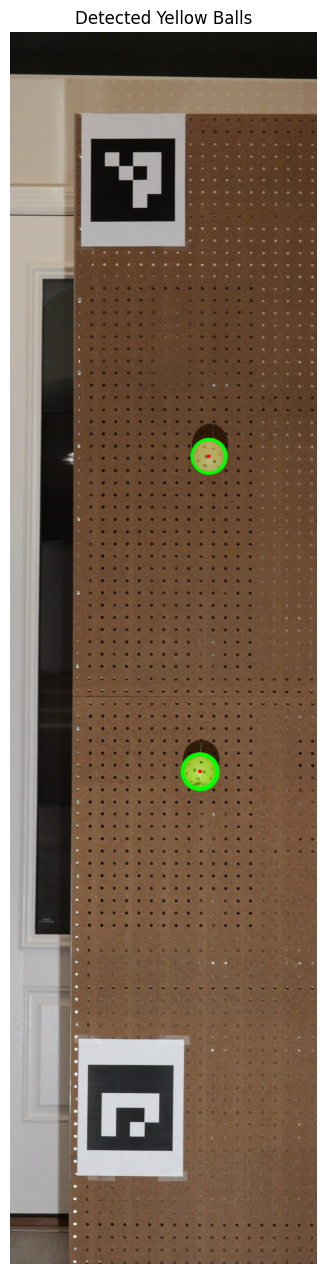

In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Your Provided Information ---
# HSV Color Range for your yellow ball
HSV_LOWER = np.array([20, 100, 100])
HSV_UPPER = np.array([40, 255, 255])

# Step 1: Convert the frame from BGR to HSV color space
hsv_frame = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2HSV)

# Step 2: Create a binary mask using the HSV range
# Pixels within the range will be white (255), others will be black (0)
mask = cv2.inRange(hsv_frame, HSV_LOWER, HSV_UPPER)

# Step 3: Clean up the mask with morphological operations
# Erode shrinks the white areas, removing small noise specks
mask = cv2.erode(mask, None, iterations=2)
# Dilate expands the white areas, closing gaps in the main objects
mask = cv2.dilate(mask, None, iterations=2)

# Step 4: Find contours in the mask
# cv2.RETR_EXTERNAL is efficient as we only care about the outer boundaries
# cv2.CHAIN_APPROX_SIMPLE saves memory by only storing endpoint vertices of lines
contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Filter and select the two largest contours
detected_balls = []
if len(contours) > 0:
    # Sort the contours by area in descending order
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Take the top two contours (if they exist)
    top_two_contours = sorted_contours[:2]

    # Step 6: Extract information and prepare for visualization
    for contour in top_two_contours:
        # Calculate the minimum enclosing circle for the contour
        ((x, y), radius) = cv2.minEnclosingCircle(contour)

        # We only consider circles with a reasonable radius to filter out noise
        if radius > min_ball_r_pixels and radius < max_ball_r_pixels:
            # Add the ball's info to our list
            detected_balls.append({
                'center': (int(x), int(y)),
                'radius': int(radius)
            })

            # --- Visualization ---
            # Draw the circle outline on the original frame
            cv2.circle(cropped_frame, (int(x), int(y)), int(radius), (0, 255, 0), 4)
            # Draw a small dot at the center of the circle
            cv2.circle(cropped_frame, (int(x), int(y)), 5, (0, 0, 255), -1)

# --- Display the final results ---

print("Detected Balls Information:")
print(detected_balls)

# Display the image with detections using Matplotlib in Jupyter
# Convert from BGR (OpenCV) to RGB (Matplotlib)
plt.figure(figsize=(8,16))
plt.imshow(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))
plt.title('Detected Yellow Balls')
plt.axis('off') # Hide the axes
plt.show()

In [41]:
def analyze_trajectory():

    # --- AUTO-CALIBRATION WITH ARUCO ---
    print("Attempting automatic calibration...")
    gray_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
    parameters = aruco.DetectorParameters()

    display_frame(first_frame)
    
    # Detect markers
    corners, ids, _ = aruco.detectMarkers(gray_frame, aruco_dict, parameters=parameters)
    
    if ids is None or len(ids) < 2:
        print("Error: Could not find both markers (ID 0 and ID 1).")
        print("Ensure they are visible and lighting is okay.")
        return

    # Find the y-center of ID 0 and ID 1
    # ids is a list of arrays, flatten it to search
    ids_flat = ids.flatten()
    
    try:
        idx0 = np.where(ids_flat == 0)[0][0]
        idx1 = np.where(ids_flat == 1)[0][0]
        
        # Calculate center Y-coordinate for each marker
        # corners[i][0] is a 4x2 array of (x,y) points for the marker square
        print(corners[idx0])
        print(corners[idx1])
        y_center_0 = corners[idx0][0][:, 1].mean()
        y_center_1 = corners[idx1][0][:, 1].mean()
        
        # Calculate calibration factor
        pixel_distance = abs(y_center_1 - y_center_0)
        pixels_per_meter = pixel_distance / REAL_DISTANCE_METERS
        
        print(f"SUCCESS: Found markers. Pixel distance: {pixel_distance:.1f}")
        print(f"CALIBRATION: {pixels_per_meter:.2f} pixels/meter")
        
    except IndexError:
        print("Error: Found markers, but not specifically ID 0 and ID 1.")
        return

Querying all available OpenCV VideoCapture properties...
{'CAP_PROP_BACKEND': 1900.0, 'CAP_PROP_BITRATE': 180660.0, 'CAP_PROP_CODEC_EXTRADATA_INDEX': 1.0, 'CAP_PROP_CODEC_PIXEL_FORMAT': 168506201.0, 'CAP_PROP_CONVERT_RGB': 1.0, 'CAP_PROP_FOURCC': 1668703592.0, 'CAP_PROP_FPS': 59.94005994005994, 'CAP_PROP_FRAME_COUNT': 18.0, 'CAP_PROP_FRAME_HEIGHT': 3840.0, 'CAP_PROP_FRAME_TYPE': 66.0, 'CAP_PROP_FRAME_WIDTH': 2160.0, 'CAP_PROP_HW_DEVICE': -1.0, 'CAP_PROP_N_THREADS': 2.0, 'CAP_PROP_ORIENTATION_AUTO': 1.0, 'CAP_PROP_ORIENTATION_META': 270.0, 'CAP_PROP_POS_AVI_RATIO': 5.555555555555556e-06, 'CAP_PROP_POS_FRAMES': 1.0, 'CAP_PROP_SAR_DEN': 1.0, 'CAP_PROP_SAR_NUM': 1.0, 'CAP_PROP_STREAM_OPEN_TIME_USEC': -9.223372036854776e+18}
Attempting automatic calibration...


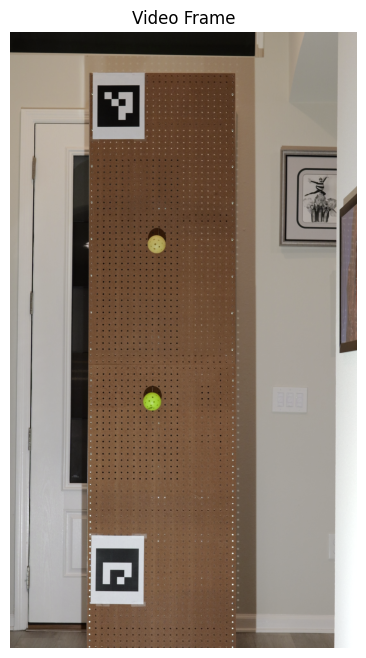

SUCCESS: Found markers. Pixel distance: 2891.5
CALIBRATION: 1504.42 pixels/meter


In [15]:
analyze_trajectory()

In [1]:
    # --- MAIN TRACKING LOOP ---
    trajectory_data = [] # To store (frame_idx, y_meters)
    frame_idx = 0
    
    # Reset to start of video for tracking
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        
        # 2. Ball Detection
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, HSV_LOWER, HSV_UPPER)
        # Clean up noise
        mask = cv2.erode(mask, None, iterations=2)
        mask = cv2.dilate(mask, None, iterations=2)
        
        cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if cnts:
            # Find largest contour (the ball)
            c = max(cnts, key=cv2.contourArea)
            
            # --- THE GEOMETRIC FIX ---
            # Use minEnclosingCircle instead of moments for center
            (x_px, y_px), radius = cv2.minEnclosingCircle(c)
            
            # Filter out tiny noise dots
            if radius > 10: # Adjust based on your ball size in pixels
                # 3. Convert to Meters
                # We can set y=0 at the top marker's position for convenience
                y_meters = (y_px - y_center_0) / pixels_per_meter
                
                trajectory_data.append((frame_idx, y_meters))
                
                # Optional: Draw on frame to visualize
                cv2.circle(frame, (int(x_px), int(y_px)), int(radius), (0, 255, 0), 2)
                cv2.circle(frame, (int(x_px), int(y_px)), 2, (0, 0, 255), 3)

        # Show frame (optional, slows down processing)
        # cv2.imshow('Tracker', frame)
        # if cv2.waitKey(1) & 0xFF == ord('q'): break
        frame_idx += 1
        
    cap.release()
    cv2.destroyAllWindows()
    
    print(f"Finished. Captured {len(trajectory_data)} data points.")
    # You now have trajectory_data ready for your physics analysis!
    # return trajectory_data

# To run it:
# analyze_trajectory()

IndentationError: unexpected indent (3274777373.py, line 2)

In [ ]:
import cv2
import cv2.aruco as aruco
import numpy as np

def start_aruco_detection():
    # 1. Initialize the Camera
    cap = cv2.VideoCapture(0)  # Use 0 for default webcam

    # 2. Define the Dictionary and Parameters
    # We use a standard dictionary (6x6 grid, 250 unique markers)
    aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    parameters = aruco.DetectorParameters()

    # 3. CAMERA CALIBRATION (CRITICAL FOR 3D)
    # NOTE: For accurate 3D data (tvec/rvec), you must calibrate your camera first.
    # These are dummy values for a standard webcam (640x480).
    # If you see wobbly axes, it's because these are approximations.
    camera_matrix = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]], dtype=float)
    dist_coeffs = np.zeros((5, 1))  # Assuming no lens distortion for simplicity

    print("Press 'q' to quit...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale (ArUco detection works best on gray)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 4. Detect Markers
        # corners: List of (x,y) arrays for each marker
        # ids: List of IDs detected
        corners, ids, rejected = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

        if ids is not None:
            # Draw the boundary box around markers
            aruco.drawDetectedMarkers(frame, corners, ids)

            # Loop through each detected marker to get its specific attributes
            for i in range(len(ids)):
                current_id = ids[i][0]
                current_corners = corners[i][0] # 4 corners of this specific marker

                # --- Attribute 1: The ID ---
                # We already have it in 'current_id'

                # --- Attribute 2: 2D Corners & Center ---
                # corners are: [top-left, top-right, bottom-right, bottom-left]
                cx = int((current_corners[0][0] + current_corners[2][0]) / 2)
                cy = int((current_corners[0][1] + current_corners[2][1]) / 2)
                
                # --- Attribute 3: 3D Pose (rvec & tvec) ---
                # defined marker size in meters (e.g., 0.05m = 5cm)
                marker_size = 0.05 
                
                # estimatePoseSingleMarkers returns the rotation and translation vectors
                rvec, tvec, _ = aruco.estimatePoseSingleMarkers(corners[i], marker_size, camera_matrix, dist_coeffs)
                
                # Draw the 3D Axis (Red/Green/Blue lines sticking out of the marker)
                cv2.drawFrameAxes(frame, camera_matrix, dist_coeffs, rvec, tvec, 0.03)

                # --- Display Information on Screen ---
                # Prepare text strings
                str_id = f"ID: {current_id}"
                str_dist = f"Dist: {tvec[0][0][2]:.2f}m" # Z-axis is distance
                
                # Print coordinates to console (optional)
                # print(f"ID: {current_id} | 2D: ({cx},{cy}) | 3D Dist: {tvec[0][0][2]:.2f}m")

                # Draw text near the marker center
                cv2.putText(frame, str_id, (cx - 10, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                cv2.putText(frame, str_dist, (cx - 10, cy + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Show the result
        cv2.imshow('ArUco Detector', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    start_aruco_detection()

The Camera Matrix (Intrinsic Parameters)The camera matrix, often denoted as $K$, is a $3 \times 3$ array that acts as the bridge between the 3D world and your 2D image sensor. It contains the intrinsic parameters of your camera—values that are internal to the physical camera and lens setup.It is structured as follows:$$K = \begin{bmatrix} 
f_x & 0 & c_x \\ 
0 & f_y & c_y \\ 
0 & 0 & 1 
\end{bmatrix}$$1. Focal Lengths ($f_x, f_y$)These values represent your lens's focal length measured in pixels, not millimeters.$f_x$: The focal length in horizontal pixels.$f_y$: The focal length in vertical pixels. (Usually equal to $f_x$ on modern square-pixel sensors).Calculation: You convert the physical focal length (e.g., 50mm) into pixels by comparing the sensor width to the image resolution width.$$f_x = \frac{\text{Focal Length (mm)} \times \text{Image Width (px)}}{\text{Sensor Width (mm)}}$$2. Optical Center ($c_x, c_y$)This represents the principal point where the optical axis of the lens hits the image sensor.$c_x$: The horizontal center (usually Image Width / 2).$c_y$: The vertical center (usually Image Height / 2).Python Function for Camera MatrixThis function allows you to input your specific resolution and crop mode settings to get the correct matrix instantly. I have set the defaults to match your Lumix S5IIX specs.

In [3]:
import numpy as np

def get_camera_matrix(resolution=(3840, 2160), focal_length_mm=50.0, sensor_mode='full_frame'):
    """
    Calculates the theoretical Intrinsic Camera Matrix (K) for a Lumix S5IIX.
    
    Parameters:
        resolution (tuple): (width, height) in pixels. Default is 4K (3840, 2160).
        focal_length_mm (float): The physical focal length of the lens in mm. Default is 50mm.
        sensor_mode (str): 'full_frame' or 'aps_c'. 
                           - Use 'full_frame' for 24p/30p (uses 35.6mm sensor width).
                           - Use 'aps_c' for 60p or crop mode (uses ~23.6mm sensor width).
    
    Returns:
        numpy.ndarray: A 3x3 Camera Matrix.
    """
    width_px, height_px = resolution
    
    # Define sensor width in millimeters based on mode
    # Lumix S5IIX Sensor: 35.6mm width (Full Frame)
    if sensor_mode == 'aps_c':
        sensor_width_mm = 23.6 # Approx APS-C crop (1.5x)
    else:
        sensor_width_mm = 35.6 # Full Frame
        
    # Calculate Focal Length in Pixels (fx, fy)
    # Formula: (Focal Length mm * Image Width px) / Sensor Width mm
    fx = (focal_length_mm * width_px) / sensor_width_mm
    fy = fx  # Square pixels imply fx == fy

    # Calculate Optical Center (cx, cy)
    cx = width_px / 2
    cy = height_px / 2

    # Construct the Matrix
    K = np.array([
        [fx,  0, cx],
        [ 0, fy, cy],
        [ 0,  0,  1]
    ], dtype=float)

    return K

In [4]:
# --- Usage Examples ---

# Example 1: Standard 4K 24p/30p (Full Frame)
matrix_standard = get_camera_matrix(sensor_mode='full_frame')
print("--- Standard 4K Matrix ---")
print(matrix_standard)

print("\n")

--- Standard 4K Matrix ---
[[5.39325843e+03 0.00000000e+00 1.92000000e+03]
 [0.00000000e+00 5.39325843e+03 1.08000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]




In [5]:
# Example 2: High Frame Rate 4K 60p (APS-C Crop)
matrix_crop = get_camera_matrix(sensor_mode='aps_c')
print("--- Cropped 4K Matrix (60p) ---")
print(matrix_crop)

--- Cropped 4K Matrix (60p) ---
[[8.13559322e+03 0.00000000e+00 1.92000000e+03]
 [0.00000000e+00 8.13559322e+03 1.08000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


You can calibrate your camera automatically using the ArUco library itself. The standard and most accurate method uses a specific pattern called a ChArUco Board.

"ChArUco" stands for Checkerboard + ArUco. It combines the sub-pixel precision of a traditional checkerboard with the versatility of ArUco markers.

Why ChArUco is better than a standard Checkerboard
Occlusion: You don't need the entire board to be visible. If the camera sees only a chunk of the board, the ArUco IDs tell the software exactly which chunk it is looking at.

Precision: The corners of the black squares provide "sub-pixel" accuracy, which is crucial for the distance measurements you are trying to get.

The Workflow
Generate a Board: You create an image file of a ChArUco board and print it out (stick it to something flat and rigid like cardboard).

Capture Images: You write a script to look at the board. You move the board around the screen (corners, edges, center) and rotate it. The script snaps a photo every time it sees a valid view.

Compute: The software takes these snapshots, compares where the corners are in the image vs. where they should be mathematically, and solves for your specific Camera Matrix.

Python Script: Automatic Calibration
This script acts as a tool. Run it, hold your printed ChArUco board in front of the camera, and press c to capture frames. Once you have about 15-20 frames, press ESC to calculate the matrix.

Note: You must first print a ChArUco board. You can generate one here (select "ChArUco").


You can calibrate your camera automatically using the ArUco library itself. The standard and most accurate method uses a specific pattern called a ChArUco Board.

"ChArUco" stands for Checkerboard + ArUco. It combines the sub-pixel precision of a traditional checkerboard with the versatility of ArUco markers.

Why ChArUco is better than a standard Checkerboard
Occlusion: You don't need the entire board to be visible. If the camera sees only a chunk of the board, the ArUco IDs tell the software exactly which chunk it is looking at.

Precision: The corners of the black squares provide "sub-pixel" accuracy, which is crucial for the distance measurements you are trying to get.

The Workflow
Generate a Board: You create an image file of a ChArUco board and print it out (stick it to something flat and rigid like cardboard).

Capture Images: You write a script to look at the board. You move the board around the screen (corners, edges, center) and rotate it. The script snaps a photo every time it sees a valid view.

Compute: The software takes these snapshots, compares where the corners are in the image vs. where they should be mathematically, and solves for your specific Camera Matrix.

Python Script: Automatic Calibration
This script acts as a tool. Run it, hold your printed ChArUco board in front of the camera, and press c to capture frames. Once you have about 15-20 frames, press ESC to calculate the matrix.

Note: You must first print a ChArUco board. You can generate one here (select "ChArUco").

In [2]:
import cv2
import cv2.aruco as aruco
import numpy as np
import os

def calibrate_camera_with_charuco():
    # 1. Configuration
    # Ensure these match the physical board you printed!
    SQUARES_VERTICALLY = 5
    SQUARES_HORIZONTALLY = 7
    SQUARE_LENGTH = 0.040 # meters (measure your printed square!)
    MARKER_LENGTH = 0.020 # meters (measure your printed marker!)
    
    dictionary = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    
    # Create the board object
    board = aruco.CharucoBoard(
        (SQUARES_HORIZONTALLY, SQUARES_VERTICALLY), 
        SQUARE_LENGTH, 
        MARKER_LENGTH, 
        dictionary
    )
    
    # Create a detector
    params = aruco.DetectorParameters()
    
    # Storage for calibration
    all_charuco_corners = []
    all_charuco_ids = []
    
    cap = cv2.VideoCapture(0) # Change index if using external camera
    
    print("--- ChArUco Calibration ---")
    print("Press 'c' to capture a frame (need min 10).")
    print("Press 'ESC' to finish and calibrate.")
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Detect Markers
        corners, ids, rejected = aruco.detectMarkers(gray, dictionary, parameters=params)
        
        # If markers are detected, try to find ChArUco corners
        if ids is not None and len(ids) > 0:
            ret_charuco, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
                corners, ids, gray, board
            )
            
            # Draw for visualization
            if charuco_corners is not None and len(charuco_corners) > 0:
                aruco.drawDetectedCornersCharuco(frame, charuco_corners, charuco_ids)
        
        cv2.imshow('Calibration', frame)
        key = cv2.waitKey(1)
        
        if key == ord('c'):
            if ids is not None and len(ids) > 0 and charuco_corners is not None:
                print(f"Frame Captured! (Total: {len(all_charuco_corners) + 1})")
                all_charuco_corners.append(charuco_corners)
                all_charuco_ids.append(charuco_ids)
            else:
                print("No board detected.")
                
        elif key == 27: # ESC key
            break

    cap.release()
    cv2.destroyAllWindows()
    
    # --- Perform Calibration ---
    if len(all_charuco_corners) > 10:
        print("Calculating Matrix... this might take a moment.")
        
        # The image size (width, height)
        img_size = (gray.shape[1], gray.shape[0])
        
        # The magic function
        ret, camera_matrix, dist_coeffs, rvecs, tvecs = aruco.calibrateCameraCharuco(
            all_charuco_corners, 
            all_charuco_ids, 
            board, 
            img_size, 
            None, 
            None
        )
        
        print("\n--- Calibration Successful ---")
        print("Camera Matrix:\n", camera_matrix)
        print("\nDistortion Coefficients:\n", dist_coeffs)
        
        # Save to file so you don't have to do this again
        np.savez("calibration_data.npz", camera_matrix=camera_matrix, dist_coeffs=dist_coeffs)
        print("Saved to 'calibration_data.npz'")
        
    else:
        print("Not enough frames captured for calibration (Need > 10).")

if __name__ == "__main__":
    calibrate_camera_with_charuco()
    

--- ChArUco Calibration ---
Press 'c' to capture a frame (need min 10).
Press 'ESC' to finish and calibrate.
Not enough frames captured for calibration (Need > 10).


[ WARN:0@0.030] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@0.031] global obsensor_uvc_stream_channel.cpp:163 getStreamChannelGroup Camera index out of range
